In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cols = ['ELASTICNETCV', 'HUBERREGRESSOR', 'LASSO', 'LinearSVR', 'QUANTILEREGRESSOR', 'XGBRegressor']

def get_data(name, dataset):
  df = pd.read_csv(f'Predictions/{name}_{dataset}_predictions.csv')
  df['Predictions'] = df[cols].agg(['idxmax'], axis=1)

  return df

In [3]:
def get_report(df):
  print(classification_report(df['class'], df['Predictions'], zero_division=0.0))

In [4]:
def balanced_acc(df):
  return balanced_accuracy_score(df['class'], df['Predictions'])

In [5]:
def plot_reliability_diagram(title, df):
  plt.figure(figsize=(12, 8))
  for c in cols:  # Loop through each class
    class_prob = df[c]
    class_binary = (df['class'] == c)  # Binary labels for this class

    # Get calibration curve
    prob_true, prob_pred = calibration_curve(class_binary, class_prob, n_bins=10, strategy='uniform')

    # Plot reliability diagram
    plt.plot(prob_pred, prob_true, label=f'Class {c} (Reliability)', marker='o')

  plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")  # Reference line
  plt.title(f'{title} Reliability Diagram')
  plt.xlabel('Mean Predicted Probability')
  plt.ylabel('Fraction of Positives')
  plt.legend()
  plt.grid()
  plt.show()

In [6]:
# source: https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d
# source: https://jamesmccaffrey.wordpress.com/2021/01/22/how-to-calculate-expected-calibration-error-for-multi-class-classification/
def expected_calibration_error(df, M=10):
  samples = df[cols]
  true_labels = df['class']
  # uniform binning approach with M number of bins
  bin_boundaries = np.linspace(0, 1, M + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  # get max probability per sample i
  confidences = np.max(samples, axis=1)
  # get predictions from confidences (positional in this case)
  predicted_label = np.argmax(samples, axis=1)

  # get a boolean list of correct/false predictions
  accuracies = predicted_label==true_labels

  ece = np.zeros(1)
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    # determine if sample is in bin m (between bin lower & upper)
    in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
    # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
    prob_in_bin = in_bin.mean()

    if prob_in_bin.item() > 0:
        # get the accuracy of bin m: acc(Bm)
        accuracy_in_bin = accuracies[in_bin].mean()
        # get the average confidence of bin m: conf(Bm)
        avg_confidence_in_bin = confidences[in_bin].mean()
        # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin

  return ece

## **Ali Sameh**

In [7]:
name = 'AliSameh'

In [8]:
train_df = get_data(name, 'train')
test_df = get_data(name, 'test')

In [9]:
train_df.head()

,ELASTICNETCV,HUBERREGRESSOR,LASSO,LinearSVR,QUANTILEREGRESSOR,XGBRegressor,class,Predictions
0,0.003927,0.060694,0.107656,0.172789,0.013423,0.641511,XGBRegressor,XGBRegressor
1,0.001145,0.017207,0.011314,0.006907,0.002872,0.960555,XGBRegressor,XGBRegressor
2,0.003329,0.967642,0.003513,0.007155,0.005037,0.013325,HUBERREGRESSOR,HUBERREGRESSOR
3,0.000598,0.003367,0.007067,0.002468,0.000700,0.985801,LinearSVR,XGBRegressor
4,0.000880,0.015250,0.024931,0.015933,0.002100,0.940907,XGBRegressor,XGBRegressor


In [10]:
print('Train predictions classification report:')
get_report(train_df)

print('\nTest predictions classification report:')
get_report(test_df)

Train predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         6
   HUBERREGRESSOR       0.20      0.21      0.21        85
            LASSO       0.13      0.13      0.13        46
        LinearSVR       0.21      0.19      0.20        69
QUANTILEREGRESSOR       0.00      0.00      0.00        17
     XGBRegressor       0.45      0.46      0.46       177

         accuracy                           0.30       400
        macro avg       0.16      0.17      0.16       400
     weighted avg       0.29      0.30      0.29       400


Test predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.25      0.36      0.30        22
            LASSO       0.00      0.00      0.00        11
        LinearSVR       0.20      0.12      0.15        17
QUANTILEREGRESSOR       0.00 

In [11]:
train_bAcc = balanced_acc(train_df)
print(f'Balanced accuracy Score for train dataset = {train_bAcc}')

test_bAcc = balanced_acc(test_df)
print(f'Balanced accuracy Score for test dataset = {test_bAcc}')

Balanced accuracy Score for train dataset = 0.16564702029178166
Balanced accuracy Score for test dataset = 0.15597147950089127


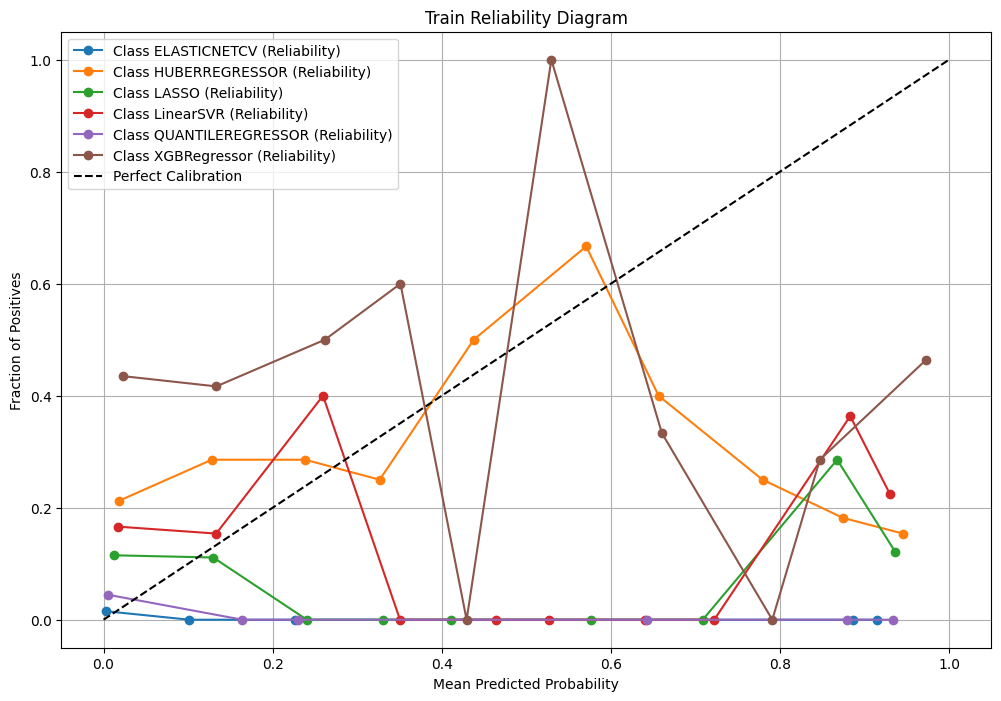

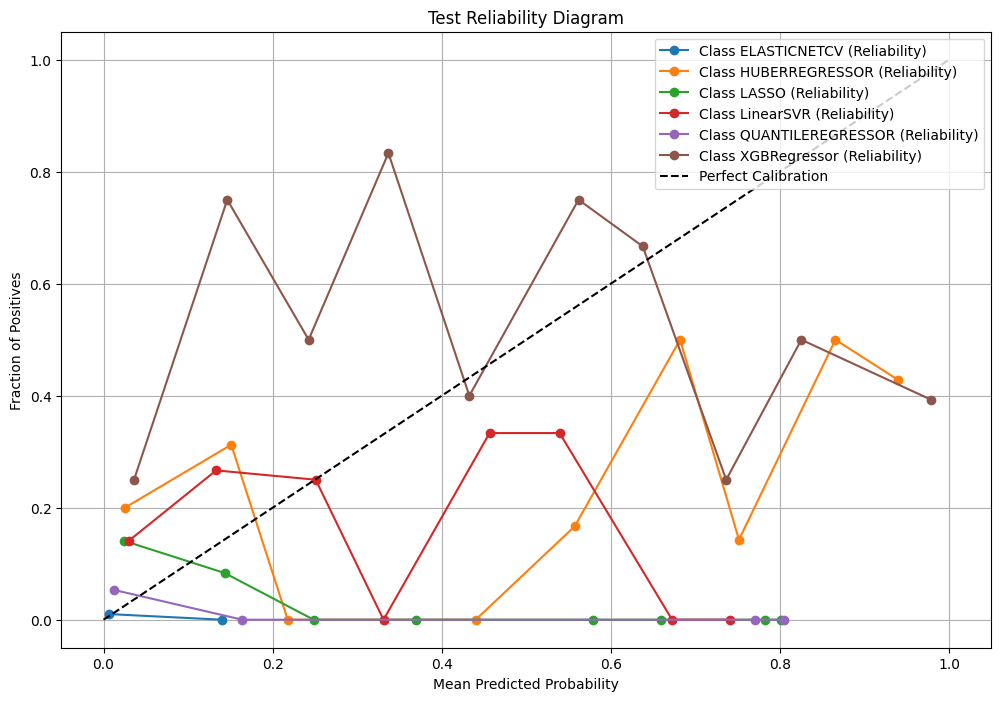

In [12]:
plot_reliability_diagram('Train', train_df)
plot_reliability_diagram('Test', test_df)

In [13]:
train_ece = expected_calibration_error(train_df)
print(f'Train ECE = {train_ece}')
test_ece = expected_calibration_error(test_df)
print(f'Test ECE = {test_ece}')

Train ECE = [0.90353045]
Test ECE = [0.73868825]


### **Observations**


*   From the performance metrics, the model suffers from underfitting.
*   From the reliability diagram, the model is overconfident especially when predicting *ELASTICNETCV*, *QUANTILEREGRESSOR*, and *LASSO* classes.

## **Hassaan Gamal**

In [14]:
name = 'HassaanGamal'

In [15]:
train_df = get_data(name, 'train')
test_df = get_data(name, 'test')

In [16]:
test_df.head()

,XGBRegressor,HUBERREGRESSOR,LASSO,LinearSVR,ELASTICNETCV,QUANTILEREGRESSOR,class,Predictions
0,0.73,0.19,0.04,0.03,0.0,0.00,XGBRegressor,XGBRegressor
1,0.05,0.61,0.09,0.18,0.0,0.06,LinearSVR,HUBERREGRESSOR
2,0.07,0.33,0.13,0.44,0.0,0.03,LinearSVR,LinearSVR
3,0.35,0.19,0.01,0.43,0.0,0.02,XGBRegressor,LinearSVR
4,0.41,0.32,0.14,0.06,0.0,0.06,XGBRegressor,XGBRegressor


In [17]:
print('Train predictions classification report:')
get_report(train_df)

print('\nTest predictions classification report:')
get_report(test_df)

Train predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       1.00      0.83      0.91         6
   HUBERREGRESSOR       0.96      0.95      0.96        85
            LASSO       0.90      0.96      0.93        46
        LinearSVR       0.96      0.93      0.94        69
QUANTILEREGRESSOR       1.00      0.88      0.94        17
     XGBRegressor       0.98      0.99      0.99       177

         accuracy                           0.96       400
        macro avg       0.97      0.92      0.94       400
     weighted avg       0.96      0.96      0.96       400


Test predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.58      0.64      0.61        22
            LASSO       0.44      0.36      0.40        11
        LinearSVR       0.33      0.18      0.23        17
QUANTILEREGRESSOR       0.40 

In [18]:
train_bAcc = balanced_acc(train_df)
print(f'Balanced accuracy Score for train dataset = {train_bAcc}')

test_bAcc = balanced_acc(test_df)
print(f'Balanced accuracy Score for test dataset = {test_bAcc}')

Balanced accuracy Score for train dataset = 0.9245059507467933
Balanced accuracy Score for test dataset = 0.4066844919786097


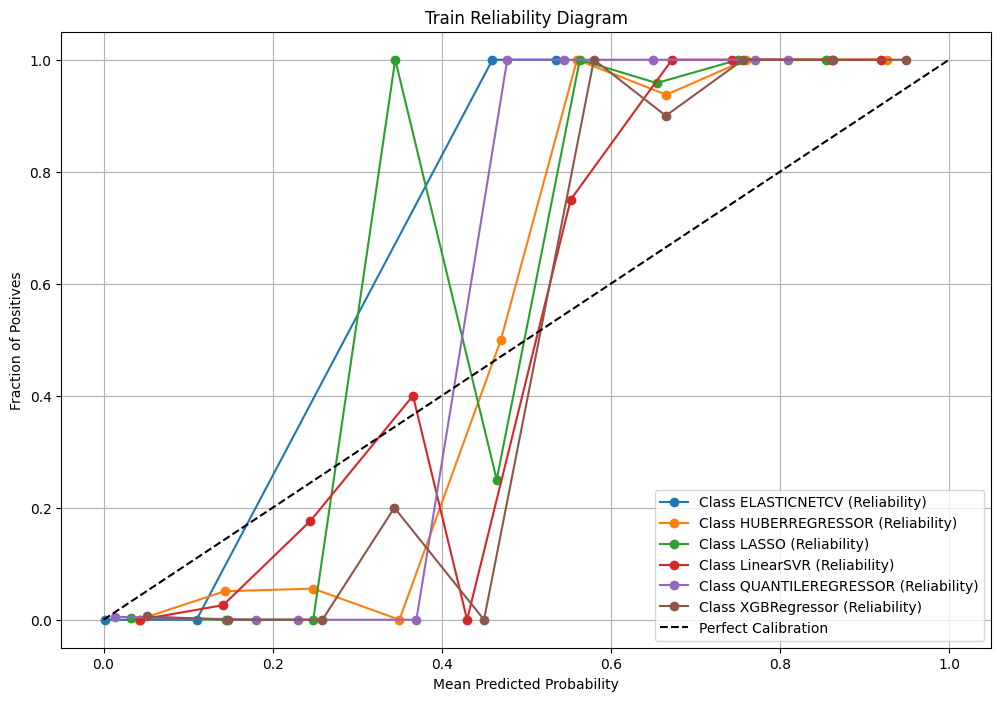

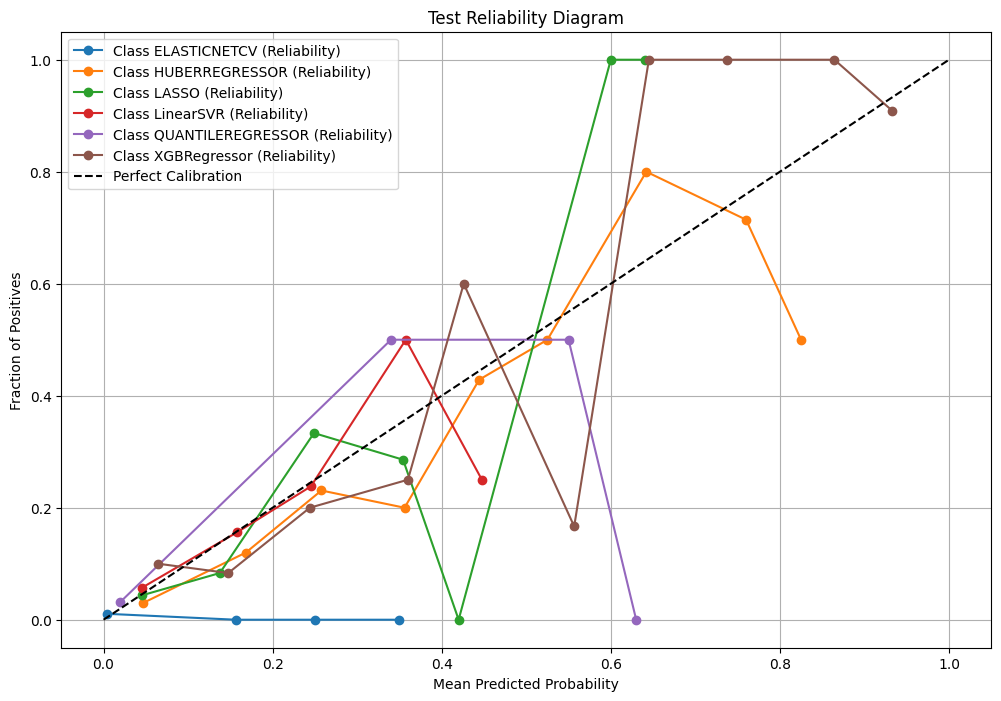

In [19]:
plot_reliability_diagram('Train', train_df)
plot_reliability_diagram('Test', test_df)

In [20]:
train_ece = expected_calibration_error(train_df)
print(f'Train ECE = {train_ece}')
test_ece = expected_calibration_error(test_df)
print(f'Test ECE = {test_ece}')

Train ECE = [0.770475]
Test ECE = [0.607]


### **Observations**

*   From the performance metrics, the model suffers from overfitting.
*   From the reliability diagram, the model is overconfident when predicting *ELASTICNETCV* class. The model is almost well-calibrated for *HUBERREGRESSOR* class. However, the model is uncalibrated over the rest of the classes.
*   Although, this model has the highest scores, there is a huge gap between the scores of the train and test data. It is overfitting and uncalibrated.


## **Yara Mahfouz**

In [28]:
name = 'YaraMahfouz'

In [29]:
train_df = get_data(name, 'train')
test_df = get_data(name, 'test')

In [30]:
test_df.head()

,ELASTICNETCV,HUBERREGRESSOR,LASSO,LinearSVR,QUANTILEREGRESSOR,XGBRegressor,class,Predictions
0,0.002089,0.055136,0.037472,0.062535,0.009085,0.833683,XGBRegressor,XGBRegressor
1,0.045097,0.470445,0.084805,0.105764,0.148943,0.144947,LinearSVR,HUBERREGRESSOR
2,0.025530,0.587953,0.067760,0.053102,0.010191,0.255464,LinearSVR,HUBERREGRESSOR
3,0.055208,0.373067,0.105024,0.310998,0.034004,0.121699,XGBRegressor,HUBERREGRESSOR
4,0.024164,0.099536,0.088375,0.081603,0.129482,0.576841,XGBRegressor,XGBRegressor


In [31]:
print('Train predictions classification report:')
get_report(train_df)

print('\nTest predictions classification report:')
get_report(test_df)

Train predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         6
   HUBERREGRESSOR       0.55      0.67      0.60        85
            LASSO       0.67      0.35      0.46        46
        LinearSVR       0.44      0.29      0.35        69
QUANTILEREGRESSOR       0.60      0.35      0.44        17
     XGBRegressor       0.73      0.90      0.81       177

         accuracy                           0.65       400
        macro avg       0.50      0.43      0.44       400
     weighted avg       0.62      0.65      0.62       400


Test predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.54      0.86      0.67        22
            LASSO       0.44      0.36      0.40        11
        LinearSVR       0.17      0.06      0.09        17
QUANTILEREGRESSOR       1.00 

In [32]:
train_bAcc = balanced_acc(train_df)
print(f'Balanced accuracy Score for train dataset = {train_bAcc}')

test_bAcc = balanced_acc(test_df)
print(f'Balanced accuracy Score for test dataset = {test_bAcc}')

Balanced accuracy Score for train dataset = 0.42658594265512645
Balanced accuracy Score for test dataset = 0.3840463458110517


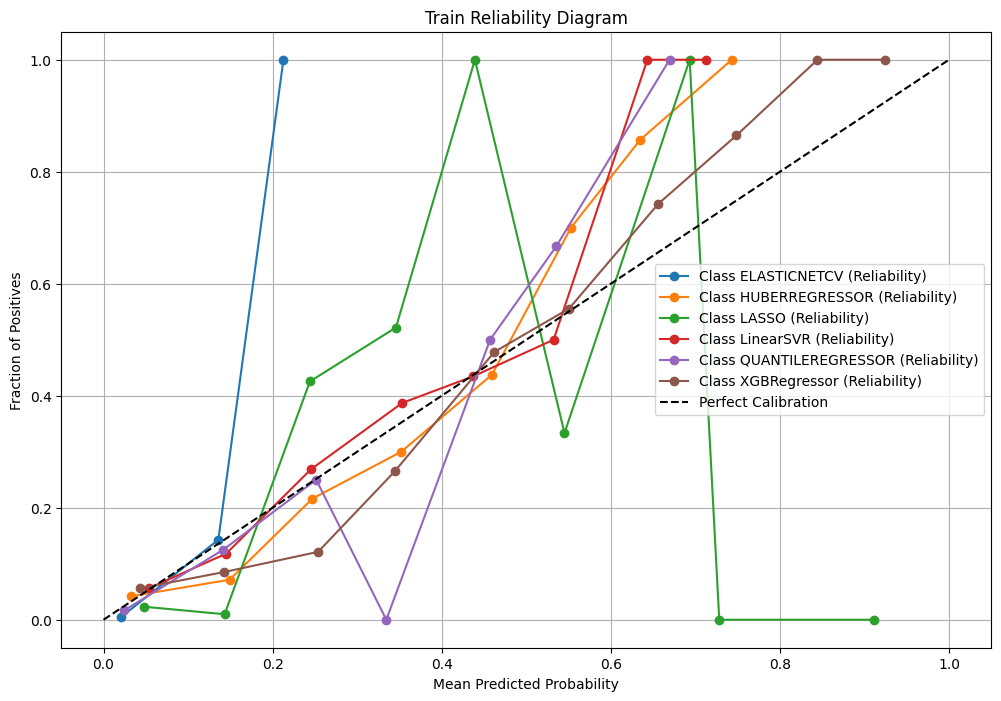

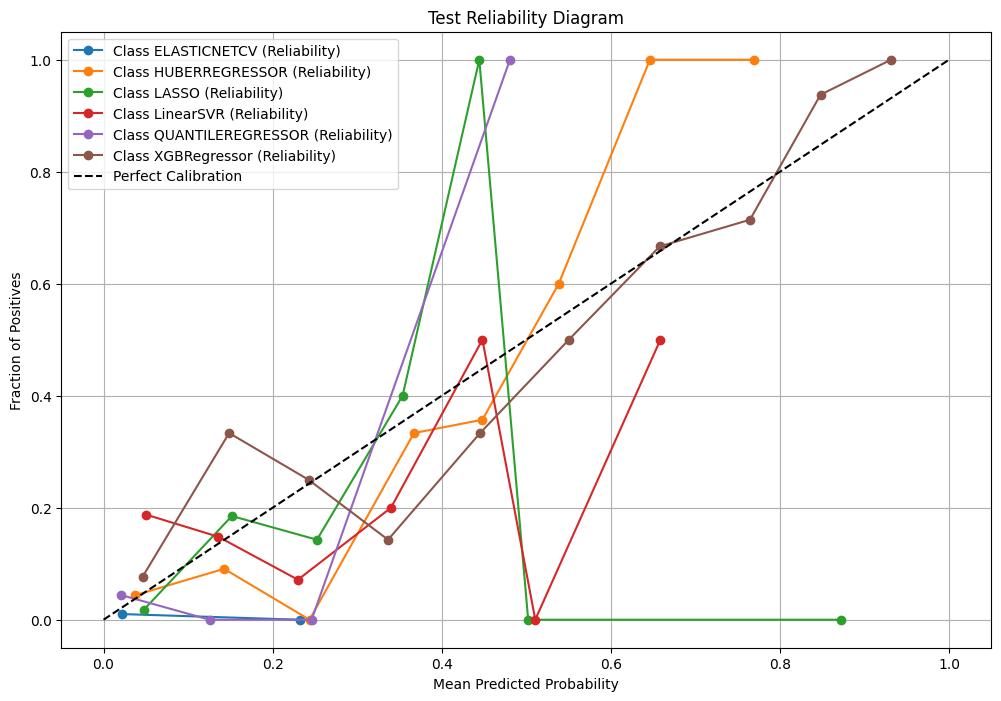

In [33]:
plot_reliability_diagram('Train', train_df)
plot_reliability_diagram('Test', test_df)

In [34]:
train_ece = expected_calibration_error(train_df)
print(f'Train ECE = {train_ece}')
test_ece = expected_calibration_error(test_df)
print(f'Test ECE = {test_ece}')

Train ECE = [0.58221682]
Test ECE = [0.6135711]


### **Observations**

*   From the performance metrics, the model has the best performance. Although the f1-score is not the highest, the model is not overfitting.
*   From the reliability diagram, the model is almost well-calibrated for *XGBRegressor* class. However, the model is uncalibrated over the rest of the classes.
*   The model's performance is similar on the train and test data, therefore, it has the best overall performance compared to the other models in this notebook.

## **Ziad Abdlhamed**

In [35]:
name = 'ZiadAbdlhamed'

In [36]:
train_df = get_data(name, 'train')
test_df = get_data(name, 'test')

In [37]:
test_df.head()

,ELASTICNETCV,HUBERREGRESSOR,LASSO,LinearSVR,QUANTILEREGRESSOR,XGBRegressor,class,Predictions
0,0.033486,0.515196,0.039135,0.177832,0.017189,0.217161,XGBRegressor,HUBERREGRESSOR
1,0.026499,0.372474,0.036382,0.166484,0.013722,0.384439,LinearSVR,XGBRegressor
2,0.028715,0.495538,0.047692,0.190878,0.015016,0.222161,LinearSVR,HUBERREGRESSOR
3,0.059271,0.464749,0.053891,0.318296,0.027899,0.075894,XGBRegressor,HUBERREGRESSOR
4,0.030526,0.437068,0.053423,0.241992,0.027074,0.209917,XGBRegressor,HUBERREGRESSOR


In [38]:
print('Train predictions classification report:')
get_report(train_df)

print('\nTest predictions classification report:')
get_report(test_df)

Train predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         6
   HUBERREGRESSOR       0.19      0.65      0.30        85
            LASSO       0.00      0.00      0.00        46
        LinearSVR       0.18      0.17      0.18        69
QUANTILEREGRESSOR       0.00      0.00      0.00        17
     XGBRegressor       0.52      0.13      0.21       177

         accuracy                           0.23       400
        macro avg       0.15      0.16      0.11       400
     weighted avg       0.30      0.23      0.19       400


Test predictions classification report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.21      0.73      0.32        22
            LASSO       0.00      0.00      0.00        11
        LinearSVR       0.18      0.12      0.14        17
QUANTILEREGRESSOR       0.00 

In [39]:
train_bAcc = balanced_acc(train_df)
print(f'Balanced accuracy Score for train dataset = {train_bAcc}')

test_bAcc = balanced_acc(test_df)
print(f'Balanced accuracy Score for test dataset = {test_bAcc}')

Balanced accuracy Score for train dataset = 0.15848589497208856
Balanced accuracy Score for test dataset = 0.15975935828877005


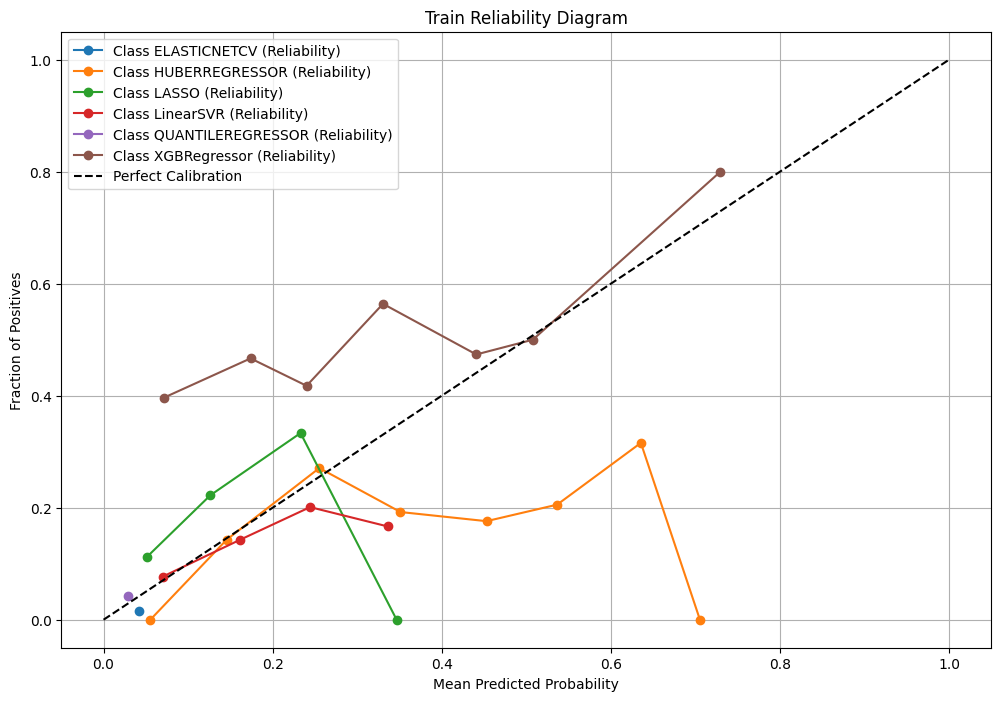

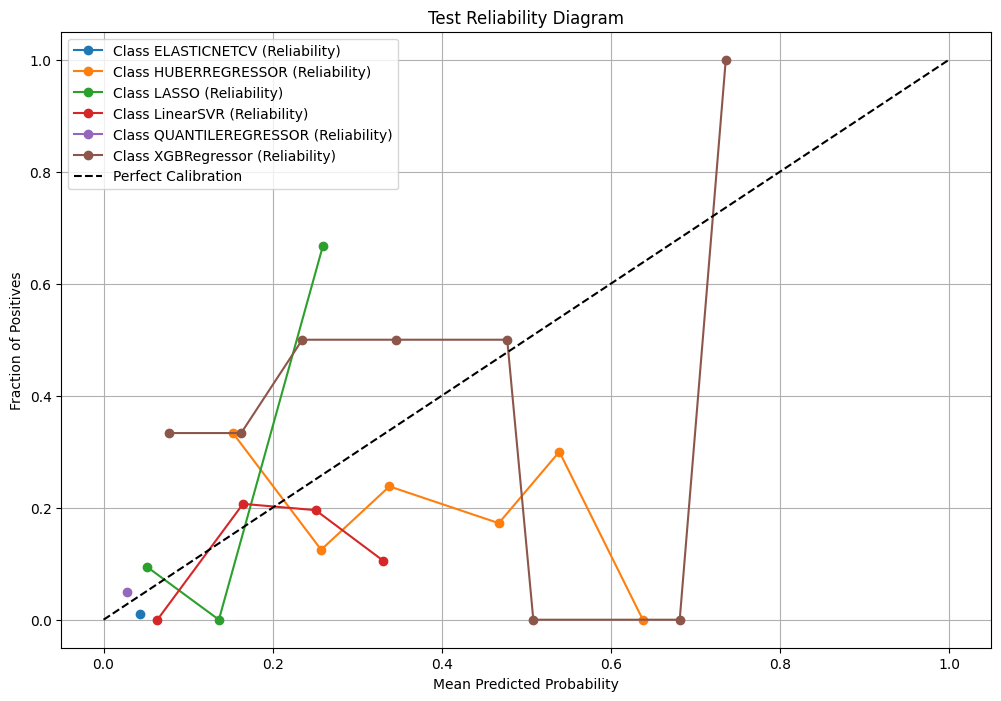

In [40]:
plot_reliability_diagram('Train', train_df)
plot_reliability_diagram('Test', test_df)

In [41]:
train_ece = expected_calibration_error(train_df)
print(f'Train ECE = {train_ece}')
test_ece = expected_calibration_error(test_df)
print(f'Test ECE = {test_ece}')

Train ECE = [0.43865412]
Test ECE = [0.45084731]


### **Observations**

*   From the performance metrics, the model suffers from underfitting.
*   From the reliability diagram, the model is uncalibrated over all the classes.